In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob

In [4]:
def get_rank(obs_ds, ensemble_ds):

    # The rank histogram is a distribution of observation rank within the ensemble
    # so to caculate it we need to know the rank of each observation at each time
    # step. We can do this by sorting the ensemble values at each time step and
    # then finding the index of the observation value within the sorted ensemble
    # values. This index should then be saved to a list.

    # First we need to parse the observation file to separate each of the observation
    # types into their own data set. This will make it easier to work with the data. 

    obs_parsed = parse_obs_netcdf(obs_ds) # this is a list of data sets 

    # Now we need to loop through each of the observation types and calculate the rank.

    name_pairs = {'SAT_SEAICE_AGREG_CONCENTR':'aice', 'SAT_SEAICE_AGREG_THICKNESS':'hi', 
                  'SAT_SEAICE_AICE01':'aice01',  'SAT_SEAICE_AICE02':'aice02',
                  'SAT_SEAICE_AICE03':'aice03',  'SAT_SEAICE_AICE04':'aice04',
                  'SAT_SEAICE_AICE05':'aice05',  'SAT_SEAICE_VICE01':'vice01',  
                  'SAT_SEAICE_VICE02':'vice02',  'SAT_SEAICE_VICE03':'vice03',  
                  'SAT_SEAICE_VICE04':'vice04',  'SAT_SEAICE_VICE05':'vice05', 
                  'SAT_SEAICE_AGREG_FREEBOARD':'fb'} 

    OBS_RANKS = []
    for name in obs_parsed.obs_name:
        var = name_pairs[name.item()]
        count = 0
        RANK = []
        for i in ensemble_ds.time:
            obs = obs_parsed.sel({'obs_name': name.item()})[count].values.item()
            
            if name in ['SAT_SEAICE_AICE01', 'SAT_SEAICE_AICE02', 'SAT_SEAICE_AICE03',
                        'SAT_SEAICE_AICE04', 'SAT_SEAICE_AICE05', 'SAT_SEAICE_VICE01', 
                        'SAT_SEAICE_VICE02', 'SAT_SEAICE_VICE03', 'SAT_SEAICE_VICE04', 
                        'SAT_SEAICE_VICE05']:
                ensemble_ds = unpack_categories(ensemble_ds)
            
            members = ensemble_ds[var].sel({'time':i}).values.tolist()
            members.append(obs)
            sorted_members = sorted(members)

            obs_rank = sorted_members.index(obs) + 1
            RANK.append(obs_rank)
            count += 1
        
        rank = xr.DataArray(RANK, dims={'time'}, coords={'time':ensemble_ds.time, 'obs_name':name})
        OBS_RANKS.append(rank)

    ranks = xr.concat(OBS_RANKS, dim = 'obs_name')

    return ranks


def parse_obs_netcdf(obs_ds):

    OBS = []
    for ob_ind in list(np.unique(obs_ds.obs_type)):
        t = obs_ds.where(obs_ds.obs_type == ob_ind, drop=True)

        obs = t.observations.sel({'copy':1}).drop('ObsIndex')

        # get the observation type name
        name = obs_ds.ObsTypesMetaData.where(obs_ds.ObsTypes == ob_ind, drop=True).values[0]
        obs['obs_name'] = name.strip().decode('utf-8')

        OBS.append(obs)
    
    obs_ds = xr.concat(OBS, dim='obs_name')

    return obs_ds


def freeboard_operator(ds):

    # calculate freeboard from the ice thickness and the snow depth

    ice_dens = 917.0
    snow_dens = 330.0
    water_dens = 1026.0

    ice_volume = ds.vice
    snow_volume = ds.vsnon.sum(dim='ncat')

    fb_volume = ice_volume * (1-ice_dens/water_dens) - snow_volume * snow_dens/water_dens

    fb = fb_volume / ds.aice 

    ds['fb'] = fb

    return ds

def unpack_categories(ds):

    # data_vars = ['aicen','vicen','vsnon']
    ncat = 5
    encd = {'aice01': {'_FillValue': None},
            'aice02': {'_FillValue': None},
            'aice03': {'_FillValue': None},
            'aice04': {'_FillValue': None},
            'aice05': {'_FillValue': None},
            'vice01': {'_FillValue': None},
            'vice02': {'_FillValue': None},
            'vice03': {'_FillValue': None},
            'vice04': {'_FillValue': None},
            'vice05': {'_FillValue': None},
            'vsno01': {'_FillValue': None},
            'vsno02': {'_FillValue': None},
            'vsno03': {'_FillValue': None},
            'vsno04': {'_FillValue': None},
            'vsno05': {'_FillValue': None}}

    # ds = xr.open_dataset(file)
    # os.rename(file, file+'~')
    # ds = ds[data_vars]

    for n in range(1,ncat+1):
        ds['aice'+'{:02}'.format(n)]=ds.aicen.isel(ncat=n-1)
        ds['vice'+'{:02}'.format(n)]=ds.vicen.isel(ncat=n-1)
        ds['vsno'+'{:02}'.format(n)]=ds.vsnon.isel(ncat=n-1)
        
    # ds=ds.drop(data_vars)

    # ds.to_netcdf(file, encoding=encd)  
    
    return ds

In [5]:
agg_obs_hc = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/synthetic_obs/free_SHEBA/netcdfs/aggregate_observations.nc')
agg_obs_lc = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/synthetic_obs/free_test/netcdfs/aggregate_observations.nc')

itd_obs = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/synthetic_obs/free_test/netcdfs/itd_observations.nc')

## FREE ENSEMBLE

In [6]:
ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/FREE/free_ens.nc')
ds = freeboard_operator(ds)

Calculate rank of the observation relative to each ensemble member

In [37]:
case = 'free_test'
agg_hc_rank = get_rank(agg_obs_hc, ds)
agg_lc_rank = get_rank(agg_obs_lc, ds)
itd_rank = get_rank(itd_obs, ds)

Plot the histograms by variable

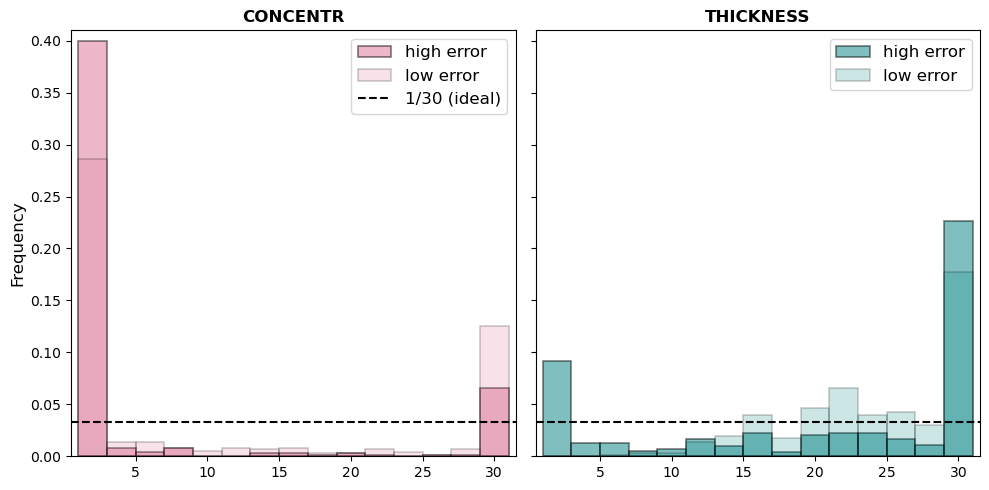

In [103]:
fig, axes = plt.subplots(ncols = 2, figsize=(10,5))
bins = np.arange(1,33,2)
count = 0
var_colors_hc = {'SAT_SEAICE_AGREG_CONCENTR':'palevioletred', 'SAT_SEAICE_AGREG_THICKNESS':'teal',}
var_colors_lc = {'SAT_SEAICE_AGREG_CONCENTR':'palevioletred', 'SAT_SEAICE_AGREG_THICKNESS':'teal',}
for n in agg_hc_rank.obs_name[1:]:
    axes[count].hist(agg_lc_rank.sel({'obs_name':n}), bins=bins, density=True, 
                     color = var_colors_lc[n.item()], alpha=0.5, edgecolor='black', #var_colors_lc[n.item()],
                     linewidth=1.2, label = 'high error')
    axes[count].hist(agg_hc_rank.sel({'obs_name':n}), bins=bins, density=True, 
                     color = var_colors_hc[n.item()], alpha=0.2, edgecolor='black', #var_colors_hc[n.item()],
                     linewidth=1.2, label = 'low error')
    
    axes[count].set_title(n.item()[17:], fontweight='bold', fontsize=12)
    axes[count].set_xlim(0.5,31.5)
    axes[count].set_ylim(0,0.41)
    if count == 0: 
        axes[count].hlines(1/30, 0.5, 31.5, color='k', linestyle='--', label = '1/30 (ideal)')
    else: 
        axes[count].hlines(1/30, 0.5, 31.5, color='k', linestyle='--')
        axes[count].set_yticklabels('')
    count += 1
    
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend(loc='upper right', fontsize=12) 
axes[1].legend(loc='upper right', fontsize=12)
plt.tight_layout()

plt.savefig('figures/FREE_aggreg_rank_histogram.png', dpi=300, bbox_inches='tight')

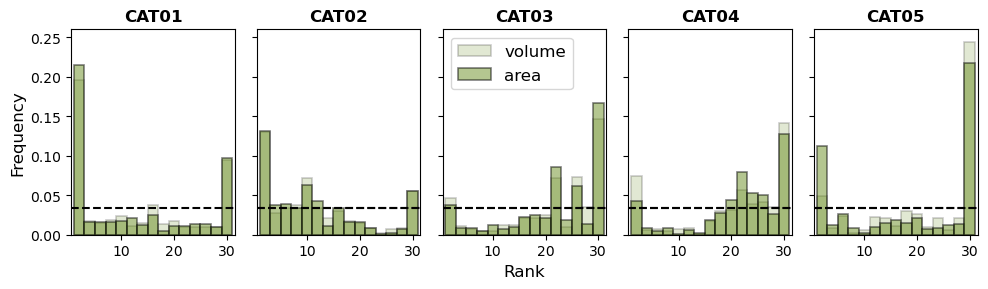

In [101]:
fig, axes = plt.subplots(ncols = 5, figsize=(10,3))
bins = np.arange(1,33,2)
count = 0

var_colors = {'SAT_SEAICE_VICE01': 'olivedrab',
              'SAT_SEAICE_VICE02': 'olivedrab', 
              'SAT_SEAICE_VICE03': 'olivedrab',
              'SAT_SEAICE_VICE04': 'olivedrab',
              'SAT_SEAICE_VICE05': 'olivedrab',
              'SAT_SEAICE_AICE01': 'olivedrab',
              'SAT_SEAICE_AICE02': 'olivedrab', 
              'SAT_SEAICE_AICE03': 'olivedrab',
              'SAT_SEAICE_AICE04': 'olivedrab',
              'SAT_SEAICE_AICE05': 'olivedrab'}

for n in itd_rank.obs_name[:5]:
    n2 = itd_rank.obs_name[count+5]
    axes[count].hist(itd_rank.sel({'obs_name':n}), bins=bins, density=True, 
                     color = var_colors[n.item()], alpha=0.2, edgecolor='black', #var_colors[n.item()],
                     linewidth=1.2, label = 'volume')
    axes[count].hist(itd_rank.sel({'obs_name':n2}), bins=bins, density=True, 
                     color = var_colors[n2.item()], alpha=0.5, edgecolor='black', #var_colors[n.item()],
                     linewidth=1.2, label = 'area')
    axes[count].set_title('CAT0'+str(count+1), fontweight='bold', fontsize=12)
    axes[count].set_xlim(0.5,31.5)
    axes[count].set_ylim(0,0.26)
    axes[count].hlines(1/30, 0.5, 31.5, color='k', linestyle='--')
    if count == 0:
        axes[count].set_ylabel('Frequency', fontsize=12)
    else:
        axes[count].hlines(1/30, 0.5, 31.5, color='k', linestyle='--')  
        axes[count].set_ylabel('')
        axes[count].set_yticklabels('')
    count += 1

axes[2].set_xlabel('Rank', fontsize=12)
axes[2].legend(loc='upper left', fontsize=12)
plt.tight_layout()

plt.savefig('figures/FREE_itd_rank_histogram.png', dpi=300, bbox_inches='tight')

## ASSIMILATED ENSEMBLES

In [166]:
var = 'SIC'
cases = [var+'_f1_BNRH_test',var+'_f101_BNRH_test']

ASSIM_ranks = []
for case in cases:
    ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/'+case+'/forecast_ens.nc')
    ds = ds.isel({'ni':2})
    ds['vice'] = ds.vicen.sum(dim='ncat')
    ds['aice'] = ds.aicen.sum(dim='ncat')
    ds['hi'] = ds.vice/ds.aice
    ds = freeboard_operator(ds)
    
    rank = get_rank(agg_obs_lc, ds)
    
    ASSIM_ranks.append(rank)

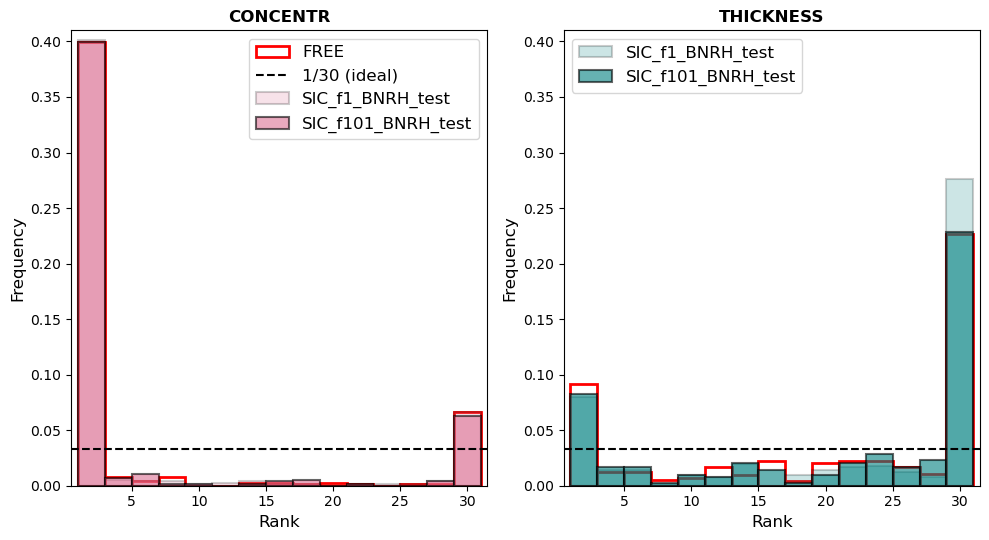

In [167]:
fig, axes = plt.subplots(ncols = 2, figsize=(10,5.5))
bins = np.arange(1,33,2)
count = 0
bas_color = 'grey'
var_colors = {'SAT_SEAICE_AGREG_CONCENTR':'palevioletred', 'SAT_SEAICE_AGREG_THICKNESS':'teal',}

count = 0
fac = 0.2
for case in cases:
    rank_curr = ASSIM_ranks[count]
    count1 = 0
    for n in agg_hc_rank.obs_name[1:]:
        
        if count == 0 and count1 == 0:
            axes[count1].hist(agg_lc_rank.sel({'obs_name':n}), bins=bins, density=True, 
                        color = 'white', edgecolor='red',#var_colors[n.item()],
                         linewidth=2, label = 'FREE')
            axes[count1].hlines(1/30, 0.5, 31.5, color='k', linestyle='--', label = '1/30 (ideal)')
        elif count == 0:
            axes[count1].hist(agg_lc_rank.sel({'obs_name':n}), bins=bins, density=True, 
                        color = 'white', edgecolor='red', #var_colors[n.item()],
                         linewidth=2)
            axes[count1].hlines(1/30, 0.5, 31.5, color='k', linestyle='--')
        
        axes[count1].hist(rank_curr.sel({'obs_name':n}), bins=bins, density=True, 
                     color = var_colors[n.item()], alpha=fac, edgecolor='black', #var_colors[n.item()],
                     linewidth=1.5, label = case)
        
        axes[count1].set_title(n.item()[17:], fontweight='bold', fontsize=12)
        axes[count1].set_xlabel('Rank', fontsize=12)
        axes[count1].set_ylabel('Frequency', fontsize=12)
        axes[count1].set_xlim(0.5,31.5)
        axes[count1].set_ylim(0,0.41)
        count1 += 1
        
    fac = fac + (1-fac)/len(ASSIM_ranks)
    count += 1

axes[0].legend(loc='upper right', fontsize=12) 
axes[1].legend(loc='upper left', fontsize=12)
plt.tight_layout()

plt.savefig('figures/'+var+'_lcs_rank_histogram.png', dpi=300, bbox_inches='tight')

In [160]:
var = 'SIT'
cases = [var+'_f1_NORM_cice',var+'_f1_BNRH_cice',var+'_f101_NORM_cice',var+'_f101_BNRH_cice']

ASSIM_ranks = []
for case in cases:
    ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/assim_data/'+case+'/filtered_ensemble.nc')
    ds['vice'] = ds.vicen.sum(dim='ncat')
    ds['aice'] = ds.aicen.sum(dim='ncat')
    ds['hi'] = ds.vice/ds.aice
    ds = freeboard_operator(ds)
    
    rank = get_rank(agg_obs_hc, ds)
    
    ASSIM_ranks.append(rank)

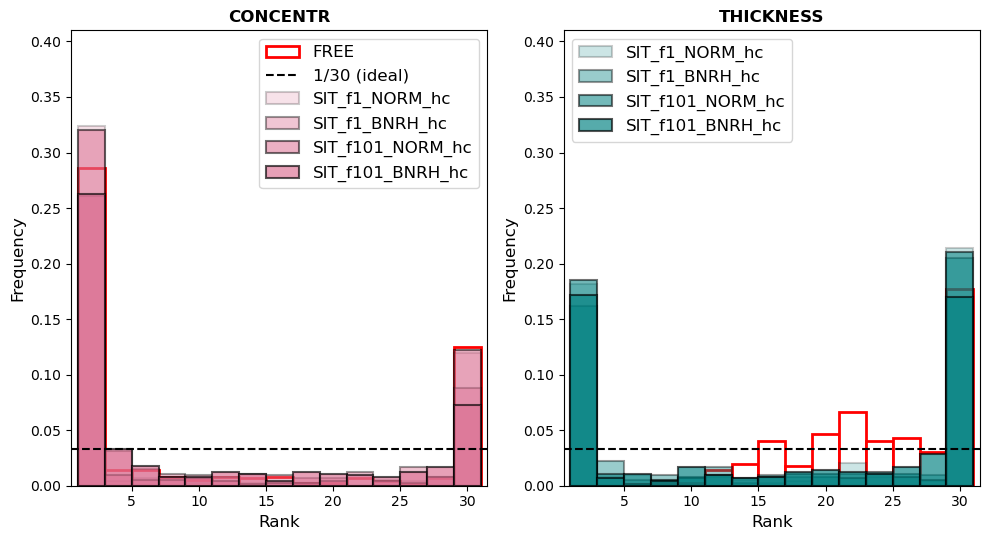

In [161]:
fig, axes = plt.subplots(ncols = 2, figsize=(10,5.5))
bins = np.arange(1,33,2)
count = 0
bas_color = 'grey'
var_colors = {'SAT_SEAICE_AGREG_CONCENTR':'palevioletred', 'SAT_SEAICE_AGREG_THICKNESS':'teal',}

count = 0
fac = 0.2
for case in cases:
    rank_curr = ASSIM_ranks[count]
    count1 = 0
    for n in agg_hc_rank.obs_name[1:]:
        
        if count == 0 and count1 == 0:
            axes[count1].hist(agg_hc_rank.sel({'obs_name':n}), bins=bins, density=True, 
                        color = 'white', edgecolor='red',#var_colors[n.item()],
                         linewidth=2, label = 'FREE')
            axes[count1].hlines(1/30, 0.5, 31.5, color='k', linestyle='--', label = '1/30 (ideal)')
        elif count == 0:
            axes[count1].hist(agg_hc_rank.sel({'obs_name':n}), bins=bins, density=True, 
                        color = 'white', edgecolor='red', #var_colors[n.item()],
                         linewidth=2)
            axes[count1].hlines(1/30, 0.5, 31.5, color='k', linestyle='--')
        
        axes[count1].hist(rank_curr.sel({'obs_name':n}), bins=bins, density=True, 
                     color = var_colors[n.item()], alpha=fac, edgecolor='black', #var_colors[n.item()],
                     linewidth=1.5, label = case[:-5]+'_hc')
        
        axes[count1].set_title(n.item()[17:], fontweight='bold', fontsize=12)
        axes[count1].set_xlabel('Rank', fontsize=12)
        axes[count1].set_ylabel('Frequency', fontsize=12)
        axes[count1].set_xlim(0.5,31.5)
        axes[count1].set_ylim(0,0.41)
        count1 += 1
        
    fac = fac + (1-fac)/len(ASSIM_ranks)
    count += 1

axes[0].legend(loc='upper right', fontsize=12) 
axes[1].legend(loc='upper left', fontsize=12)
plt.tight_layout()

plt.savefig('figures/'+var+'_hcs_rank_histogram.png', dpi=300, bbox_inches='tight')

In [191]:
var = 'VIC'
cases = [var+'_f1_NORM_test', var+'_f101_BNRH_test']

ASSIM_ranks = []
for case in cases:
    ds = xr.open_dataset('/glade/u/home/mollyw/work/Projects/cice-scm-da/data/processed/'+case+'/forecast_ens.nc')
    ds = ds.isel({'ni':2})
    ds['vice'] = ds.vicen.sum(dim='ncat')
    ds['aice'] = ds.aicen.sum(dim='ncat')
    ds['hi'] = ds.vice/ds.aice
    ds = freeboard_operator(ds)
    
    rank = get_rank(itd_obs_lc, ds)
    
    ASSIM_ranks.append(rank)

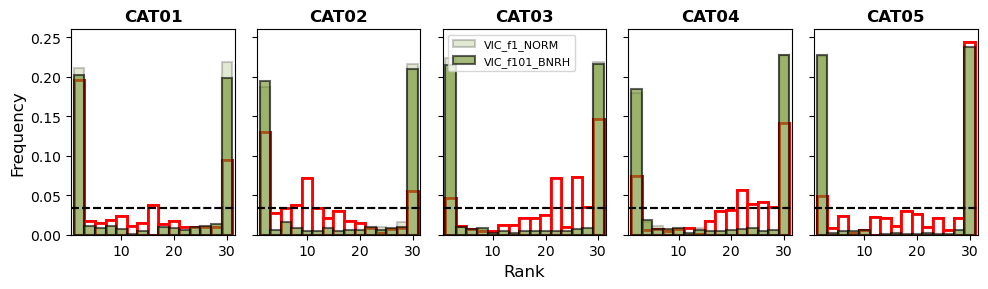

In [192]:
fig, axes = plt.subplots(ncols = 5, figsize=(10,3))
bins = np.arange(1,33,2)
count = 0
bas_color = 'grey'
var_colors = 'olivedrab' 

count = 0
fac = 0.2
for case in cases:
    rank_curr = ASSIM_ranks[count]
    count1 = 0
    for n in itd_rank.obs_name[:5]:
        axes[count1].hist(itd_rank.sel({'obs_name':n}), bins=bins, density=True, 
                        color = 'white', edgecolor='red', #var_colors[n.item()],
                         linewidth=2)
        axes[count1].hlines(1/30, 0.5, 31.5, color='k', linestyle='--')
        
        axes[count1].hist(rank_curr.sel({'obs_name':n}), bins=bins, density=True, 
                     color = var_colors, alpha=fac, edgecolor='black', #var_colors[n.item()],
                     linewidth=1.5, label = case[:-5])
        axes[count1].set_title('CAT0'+str(count1+1), fontweight='bold', fontsize=12)
        axes[count1].set_xlim(0.5,31.5)
        axes[count1].set_ylim(0,0.26)
        if count1 != 0:
            axes[count1].set_yticklabels('')
        count1 += 1
        
    fac = fac + (1-fac)/len(ASSIM_ranks)
    count += 1

axes[2].set_xlabel('Rank', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[2].legend(loc='upper left', fontsize=8) 
plt.tight_layout()

plt.savefig('figures/'+var+'_rank_histogram.png', dpi=300, bbox_inches='tight')